In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter, GlobalObjective
from refnx.reflect import SLD, Slab, ReflectModel, LipidLeaflet
# from sepObjectiveGO import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
# from CFitter import CFitter
# import make_sim_data as msd
# import lipidBilayerAsGiven.SLD_maker 
import data_in as di
import lipidBilayerAsGiven.Bilayer as bl
import lipidBilayerAsGiven.Popg as Pg
import lipidBilayerAsGiven.Popc as Pc
import lipidBilayerAsGiven.Dodab as ml

print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))
%matplotlib inline
SEED = 12345

refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


csv
cvs-collecting
csv
cvs-collecting


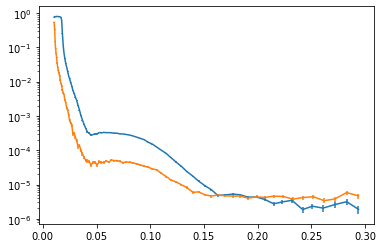

In [2]:
dataD2o = Data1D(data=di.data_in("lipidBilayerData/54696_97_edit.txt"))
dataD2o.name="d2o"
dataPmw = Data1D(data=di.data_in("lipidBilayerData/54699_00_edit.txt"))
dataPmw.name="pmw"

plt.errorbar(dataD2o.data[0],dataD2o.data[1],dataD2o.data[2])
plt.errorbar(dataPmw.data[0],dataPmw.data[1],dataPmw.data[2])
plt.yscale("log")
plt.show()

In [3]:
name = "bilayer"

d2o = SLD(6.07, "D2O")
pmw = SLD(2.35, "Protein Matched Water")
air = SLD(0.00, "Air")

d2o.real.setp(vary=True, bounds=(5.35, 6.35))
pmw.real.setp(vary=True, bounds=(1.35, 3.35))


apm = Parameter(value=62, name='%s - area_per_molecule' % name,
                bounds=(60, 150), vary=True)

#Define all the neutron b's
bc = 0.6646e-4  #Carbon
bo = 0.5804e-4  #Oxygen
bh = -0.3739e-4 #Hydrogen
bp = 0.513e-4   #Phosphorus
bn = 0.936e-4   #Nitrogen
bd = 0.6671e-4  #Deuterium

#Formulae of the molecule sections...
CH2 = (1*bc) + (2*bh)
CH = (1*bc) + (1*bh)
CH3 = (1*bc) + (3*bh)
D2O = (2*bd) + (1*bo)
H2O = (2*bh) + (1*bo)

# Calculate mole fraction of D2O from the bulk SLD..
# d2o_molfr = (1/D2O-H2O)*(contrast*27.64)-H2O
# wMol = (d2o_molfr * D2O) + ((1-d2o_molfr)*H2O)

#sum b's of all the different fragments
b_tails = Parameter(value=(28*CH2) + (2*CH) + (2*CH3),
                       name='%s - b_tails_real' % name)

sum_popc_heads = (8*bo) + (1*bp) + (1*bn) + (2*bc) + (4*CH2) + (3*CH3) + (1*CH)
sum_popg_heads = (10*bo) + (1*bp) + (2*bc) + (4*CH2) + (2*CH) + (2*bh)
b_heads = Parameter(value=(3*(sum_popc_heads) + (sum_popg_heads))/4,
                        name='%s - b_heads_real' % name)

#monolayer compositions
#sum_m_tails = (34*CH2) + (2*CH3);
#sum_m_heads = (1*bn) + (2*CH3) + (Waters_per_headD * wMol);

#volumes of each fragment
vCH2 = 27.7
nCH2 = 30
vCH3 = 54.6
vm_tails = Parameter(value=(nCH2 * vCH2) + (2 * vCH3),
            name='%s - volume_tails' % name) #
vm_heads = Parameter(value=331,
            name='%s - volume_heads' % name)  #

#thickness
thickness_tails = Parameter(value=vm_tails.value/apm.value,
            name='%s - thickness_tails' % name,
            bounds=((1-0.75)*vm_tails.value/apm.value,
                    (1+0.75)*vm_tails.value/apm.value),
               vary=True)
thickness_heads = Parameter(value=vm_heads.value/apm.value,
            name='%s - thickness_heads' % name,
            bounds=((1-0.75)*vm_heads.value/apm.value,
                    (1+0.75)*vm_heads.value/apm.value),
               vary=True)

rough_top = Parameter(value=12.0,
            name='%s - rough_top' % name,
            bounds=(0,20), vary=True)
rough_bot = Parameter(value=10.3,
            name='%s - rough_bot' % name,
            bounds=(0,15), vary=True)

In [4]:
# apm, b_heads, vm_heads, thickness_heads
# b_tails, vm_tails, thickness_tails, rough_head_tail
# rough_preceding_mono, head_solvent


head_solvent_d2o = SLD(6.07, "D2O in bilayer")
head_solvent_d2o.real.setp(6.07, vary=True, bounds=(5.35, 6.35))
upper_lipid_d2o = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
b_tails, vm_tails, thickness_tails, rough_top,
rough_top, head_solvent_d2o, reverse_monolayer=False)

lower_lipid_d2o = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
b_tails, vm_tails, thickness_tails, rough_top,
rough_top, head_solvent_d2o, reverse_monolayer=True)


head_solvent_pmw = SLD(2.35, "Protein Matched Water in bilayer")
head_solvent_pmw.real.setp(2.34, vary=True, bounds=(1.35, 3.35))
upper_lipid_pmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
b_tails, vm_tails, thickness_tails, rough_bot,
rough_bot, head_solvent_pmw, reverse_monolayer=False)

lower_lipid_pmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
b_tails, vm_tails, thickness_tails, rough_bot,
rough_bot, head_solvent_pmw, reverse_monolayer=True)


In [5]:
name_m = "mono, dodab"
APMD = Parameter(value=48, name='%s - area_per_molecule' % name_m,
        bounds=(30,120), vary=True)

# monolayer compositions
m_tails = Parameter(value=(34*CH2) + (2*CH3),
            name='%s - b_tails_real' % name_m)
m_heads = Parameter(value=(1*bn) + (2*CH3),
            name='%s - b_heads_real' % name_m)

# monolayer volumes
vm_m_tails = Parameter(value=vCH2*36,
            name='%s - volume_tails' % name)
vm_m_heads = Parameter(value=54.6,
            name='%s - volume_heads' % name)

# monolayer thicknesses
tail_thick_m = Parameter(value=vm_m_tails.value / APMD.value,
            name='%s - thickness_tails' % name,
            bounds=((1-0.75)*vm_m_tails.value / APMD.value,
                    (1+0.75)*vm_m_tails.value / APMD.value),
               vary=True)
head_thick_m = Parameter(value=vm_m_heads.value / APMD.value,
            name='%s - thickness heads' % name,
            bounds=((1-0.75)*vm_m_heads.value / APMD.value,
                    (1+0.75)*vm_m_heads.value / APMD.value),
               vary=True)

roughness_m =  Parameter(value=5.8,
            name='%s - roughness' % name,
            bounds=(0,10), vary=True)

In [6]:

m_head_solvent_pmw=SLD(2.35, "mono, dodab - Protein Matched Water in head")
m_head_solvent_pmw.real.setp(2.34, vary=True, bounds=(1.35, 3.35))
m_air_in_tail=SLD(0, "mono, dodab - air in tail")

dodab_pmw = LipidLeaflet(apm=APMD, b_heads=m_heads, vm_heads=vm_m_heads,
thickness_heads=head_thick_m, b_tails=m_tails, vm_tails=vm_m_tails,
thickness_tails=tail_thick_m, rough_head_tail=roughness_m,
rough_preceding_mono=roughness_m, head_solvent=m_head_solvent_pmw, tail_solvent=m_air_in_tail) #mono

m_head_solvent_d2o=SLD(6.07, "mono, dodab - D2O in head")
m_head_solvent_d2o.real.setp(6.07, vary=True, bounds=(5.35, 6.35))
dodab_d2o = LipidLeaflet(apm=APMD, b_heads=m_heads, vm_heads=vm_m_heads,
thickness_heads=head_thick_m, b_tails=m_tails, vm_tails=vm_m_tails,
thickness_tails=tail_thick_m, rough_head_tail=roughness_m,
rough_preceding_mono=roughness_m, head_solvent=m_head_solvent_d2o, tail_solvent=m_air_in_tail) #mono

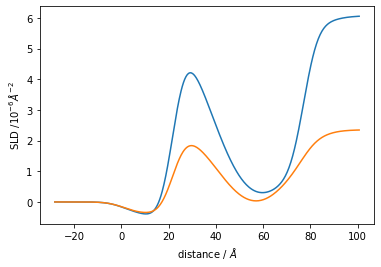

________________________________________________________________________________
Structure:                
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
LipidLeaflet(Parameter(value=48.0, name='mono, dodab - area_per_molecule', vary=True, bounds=Interval(lb=30, ub=120), constraint=None), SLD([Parameter(value=2.1799999999999825e-06, name='mono, dodab - b_heads_real', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.0, name=' - b_heads_imag', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), const

In [7]:
structure_d2o = air(0, 0) | dodab_d2o | d2o(0, 0) | upper_lipid_d2o | lower_lipid_d2o | d2o(0, 0)
structure_pmw = air(0, 0) | dodab_pmw | pmw(0, 0) | upper_lipid_pmw | lower_lipid_pmw | pmw(0, 0)


solution_thickness = Parameter(value=14.3, bounds=(6, 20), vary=True,
            name='%s - thickness_solution' % name)

rough_preceding_solution = Parameter(value=4.6, bounds=(0, 20), vary=True,
            name='%s - rough_preceding_solution' % name)

structure_d2o[2].thick=solution_thickness#.setp(14.3, vary=True, bounds=(6, 20))
structure_d2o[2].rough=rough_preceding_solution#.setp(4.6, vary=True, bounds=(3, 20))
structure_pmw[2].thick=solution_thickness
structure_pmw[2].rough=rough_preceding_solution

structure_d2o[5].thick=solution_thickness
structure_d2o[5].rough=rough_preceding_solution
structure_pmw[5].thick=solution_thickness
structure_pmw[5].rough=rough_preceding_solution

# structure_d2o
# structure_pmw

plt.plot(*structure_d2o.sld_profile(),label=structure_d2o)
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.plot(*structure_pmw.sld_profile(),label=structure_pmw)
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.show();
# print(structure_d2o)
print(structure_pmw)

In [8]:
model1 = ReflectModel(structure_d2o)
model1.scale.setp(0.75, vary=True, bounds=(0.5, 1.5))
model1.bkg.setp(dataD2o.y.min(),vary=True,bounds=(dataD2o.y.min() * 0.2, dataD2o.y.min() * 1.8))

model2 = ReflectModel(structure_pmw)
model2.scale.setp(0.75, vary=True, bounds=(0.5, 1.5))
model2.bkg.setp(dataPmw.y.min(),vary=True,bounds=(dataPmw.y.min() * 0.2, dataPmw.y.min() * 1.8))

objective1 = Objective(model1, dataD2o, transform=Transform("logY"))
objective2 = Objective(model2, dataPmw, transform=Transform("logY"))
gobjective = GlobalObjective([objective1,objective2])

if True:
    fitter = CurveFitter(gobjective)
    fitter.fit("differential_evolution", target="nlpost")#, seed=SEED)


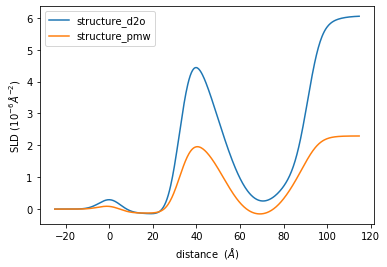

In [9]:
# structure_d2o
# structure_pmw
plt.plot(*structure_d2o.sld_profile(),label="structure_d2o")
# structure_d2o.plot()
# plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
# plt.xlabel('distance  $(\AA)$')

plt.plot(*structure_pmw.sld_profile(),label="structure_pmw")
# structure_pmw.plot()
plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
plt.xlabel('distance  $(\AA)$')
plt.legend()
plt.show();

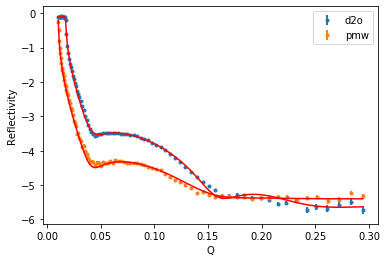

In [10]:
gobjective.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

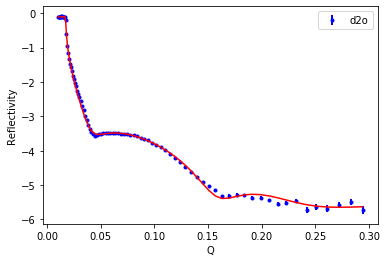

In [14]:
objective1.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

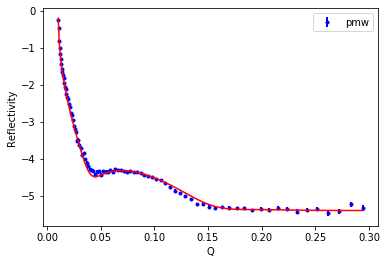

In [15]:
objective2.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

In [11]:
print("model1: d2o", model1.scale, model1.bkg)
print("model2: pmw", model2.scale, model2.bkg)

model1: d2o <Parameter:    'scale'    , value=0.783268 +/- 0.00199, bounds=[0.5, 1.5]> <Parameter:     'bkg'     , value=2.22889e-06 +/- 2.47e-07, bounds=[3.72e-07, 3.348e-06]>
model2: pmw <Parameter:    'scale'    , value=0.657975 +/- 0.0116, bounds=[0.5, 1.5]> <Parameter:     'bkg'     , value=3.97755e-06 +/- 1.54e-07, bounds=[6.74e-07, 6.066e-06]>


In [12]:
print(structure_d2o)

________________________________________________________________________________
Structure:                
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
LipidLeaflet(Parameter(value=95.43072615593623, name='mono, dodab - area_per_molecule', vary=True, bounds=Interval(lb=30, ub=120), constraint=None), SLD([Parameter(value=2.1799999999999825e-06, name='mono, dodab - b_heads_real', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.0, name=' - b_heads_imag', vary=False, bounds=Interval(lb=-np.inf, ub=n

In [13]:
print(structure_pmw)

________________________________________________________________________________
Structure:                
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
LipidLeaflet(Parameter(value=95.43072615593623, name='mono, dodab - area_per_molecule', vary=True, bounds=Interval(lb=30, ub=120), constraint=None), SLD([Parameter(value=2.1799999999999825e-06, name='mono, dodab - b_heads_real', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.0, name=' - b_heads_imag', vary=False, bounds=Interval(lb=-np.inf, ub=n